<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/9-image-segmentation/2_instance_segmentation_with_mask_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instance Segmentation using Mask R-CNN

The Mask R-CNN architecture helps in identifying/highlighting the instances of
objects of a given class within an image. This comes in especially handy when there are multiple objects of the same type present within the image. Furthermore, the term Mask represents the segmentation that's done at the pixel level by Mask R-CNN.

The Mask R-CNN architecture is an extension of the Faster R-CNN network. However, a few modifications have been made to the Mask R-CNN architecture, as follows:
- The RoI Pooling layer has been replaced with the RoI Align layer.
- A mask head has been included to predict a mask of objects in addition to
the head, which already predicts the classes of objects and bounding box
correction in the final layer.
- A fully convolutional network (FCN) is leveraged for mask prediction.

Let's have a quick look at the events that occur within Mask R-CNN before we
understand how each of the components works (image source: https://arxiv.org/pdf/1703.06870.pdf):

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/MaskR-CNN.png?raw=1' width='800'/>

In the preceding diagram, note that we are fetching the class and bounding box
information from one layer and the mask information from another layer.

The working details of the Mask R-CNN architecture are as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/Mask R-CNN-architecture.png?raw=1' width='800'/>


## Setup

In [1]:
%%shell

pip install -qU torch_snippets
pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 204kB 32.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 


In [2]:
%%shell

wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py

In [3]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from sklearn.model_selection import train_test_split

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[05/11/21 09:57:19] WARNING  Not importing Lightning Report      ]8;id=1620727039.6008863-25841;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

[05/11/21 09:57:20] WARNING  sklearn is not found. Skipping relevant  ]8;id=1620727040.3423588-859683;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`                                
                             Exception: No module named 'sklego'

In [4]:
%%shell

wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar

tar -xf images.tar
tar -xf annotations_instance.tar

rm images.tar annotations_instance.tar

## RoI Align

One of the drawbacks of RoI Pooling is that we are likely to lose certain information when we are performing the RoI pooling operation. This is because we are likely to have an even representation of content across all the areas of an image before pooling.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align.png?raw=1' width='800'/>

In the preceding image, the region proposal is `5 x 7` in shape and we have to convert it into a `2 x 2` shape. While converting it into a `2 x 2` shape (a phenomenon called quantization), one part of the region has less representation compared to other parts of the region. This results in information loss since certain parts of the region have more weight than others. RoI Align comes to the rescue to address such a scenario.

To understand how RoI Align works, let's go through a simple example. Here, we are trying to convert the following region (which is represented in dashed lines) into a `2 x 2` shape:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align1.png?raw=1' width='800'/>


Note that the region (in dashed lines) is not equally spread across all the cells in the feature map.

We must perform the following steps to get a reasonable representation of the region in a `2 x 2` shape:

1. First, divide the region into an equal `2 x 2` shape:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align2.png?raw=1' width='800'/>

2. Define four points that are equally spaced within each of the `2 x 2` cells:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align3.png?raw=1' width='800'/>

Note that, in the preceding diagram, the distance between two consecutive
points is 0.75.

3. Calculate the weighted average value of each point based on its distance to
the nearest known value:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align4.png?raw=1' width='800'/>

4. Repeat the preceding interpolation step for all four points in a cell:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align5.png?raw=1' width='800'/>

5. Perform average pooling across all four points within a cell:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/roi-align6.png?raw=1' width='800'/>

By implementing the preceding steps, we don't lose out on information when
performing RoI Align; that is, when we place all the regions inside the same shape.

##Mask head

Using RoI Align, we can get a more accurate representation of the region proposal that is obtained from the Region Proposal Network. Now, we want to obtain the segmentation (mask) output, given a standard shaped RoI Align output, for every region proposal.

Typically, in the case of object detection, we would pass the RoI Align through a flattened layer in order to predict the object's class and bounding box offset.

However, in the case of image segmentation, we predict the pixels within a bounding box that contains the object. Hence, we now have a third output (apart from class and bounding box offset), which is the predicted mask within the region of interest.

Here, we are predicting the mask, which is an image overlay on top of the original image. Given that we are predicting an image, instead of flattening the RoI Align's output, we'll connect it to another convolution layer to get another image-like structure (width x height in dimension).

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/mask-head1.png?raw=1' width='800'/>

In the preceding diagram, we have obtained an output of shape `7 x 7 x 2048` using the feature pyramid network (FPN), which now has 2 branches:

- The first branch returns the class of the object and the bounding box, post
flattening the FPN output.
- The second branch performs convolution on top of the FPN's output to get
a mask.

The ground truth corresponding to the `14 x 14` output is the resized image of the region proposals. The ground truth of the region proposal is of the shape `80 x 14 x 14` if there are `80` unique classes in the dataset. Each of the `80 x 14 x 14` pixels is a `1` or a `0`, which indicates whether the pixel contains an object or not. Thus, we are performing
binary cross-entropy loss minimization while predicting the class of a pixel.

Post model training, we are able to detect regions, get classes, get bounding box offsets, and get the mask corresponding to each region. When making an inference, we first detect the objects present in the image and make bounding box corrections. Then, we pass the offsetted region to the mask head to predict the mask that corresponds to different pixels in the region.

## Implementing instance segmentation

To help us understand how to code Mask R-CNN for instance segmentation, we will leverage a dataset that masks people who are present within an image. The dataset we'll be using has been created from a subset of the ADE20K dataset, which is available at https://groups.csail.mit.edu/vision/datasets/ADE20K/. We will only use those images where we have masks for people.

The strategy that we'll adopt is as follows:

1. Fetch the dataset and then create datasets and dataloaders from it.
2. Create a ground truth in a format needed for PyTorch's official
implementation of Mask R-CNN.
3. Download the pre-trained Faster R-CNN model and attach a Mask R-CNN
head to it.
4. Train the model with a PyTorch code snippet that has been standardized
for training Mask R-CNN.
5. Infer on an image by performing non-max suppression first and then
identifying the bounding box and the mask corresponding to the people in
the image.

**Step-1:** Fetch images that contain masks of people.

In [5]:
# Loop through the images and annotations_instance folders to fetch filenames
all_images = Glob("images/training")
all_annots = Glob("annotations_instance/training")

[05/11/21 09:59:46] INFO     20210 files found at   ]8;id=1620727186.9714854-69335;file://<ipython-input-5-a6819ffe36b0>\<ipython-input-5-a6819ffe36b0>]8;;\:<module>:2
                             images/training

[05/11/21 09:59:47] INFO     20210 files found at a ]8;id=1620727187.0350225-794720;file://<ipython-input-5-a6819ffe36b0>\<ipython-input-5-a6819ffe36b0>]8;;\:<module>:3
                             nnotations_instance/tr                                          
                             aining

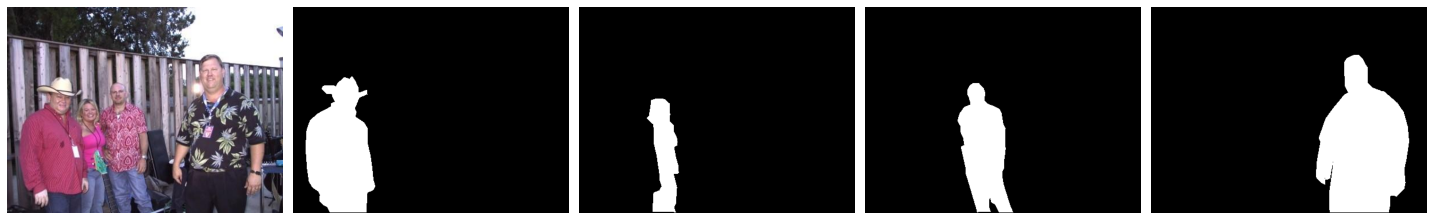

In [6]:
# Inspect the original image and the representation of masks of instances of people.
f = "ADE_train_00014301"

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2, 0, 1)

r, g, b = an

# 4 stands for person
nzs = np.nonzero(r==4)
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))

for ix, _id in enumerate(instances):
  masks[ix] = g == _id

subplots([im, *masks], sz=20)

From the preceding image, we can see that a separate mask has been
generated for each person. Here, there are four instances of the Person
class.

> In this particular dataset, the ground truth instance annotations are
provided in such a way that the Red channel in RGB corresponds to
the class of object, while the Green channel corresponds to the
instance number (in case there are multiple objects of the same class
in the image – as in our example here). Furthermore, the Person
class is encoded with a value of 4.



In [7]:
# Loop through the annotations and store the files that contain at least one person:
annots = []

for ann in Tqdm(all_annots):
  _ann = read(ann, 1).transpose(2, 0, 1)
  r, g, b = _ann
  if 4 not in np.unique(r):
    continue
  annots.append(ann)

100%|██████████| 20210/20210 [02:03<00:00, 163.12it/s]


In [8]:
# Split the files into training and validation files
_annots = stems(annots)
train_items, val_items = train_test_split(_annots, random_state=2)

**Step-2:** Define the transformation method.

In [ ]:
train_ds = SegmentationData("train")
val_ds = SegmentationData("test")

train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)
val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

[04/12/21 09:21:49] INFO     367 files found at                           ]8;id=1618219309.662518-981252;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py\loader.py]8;;\:stems:198
                             dataset1/images_prepped_train

                    INFO     101 files found at                           ]8;id=1618219309.669717-878539;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py\loader.py]8;;\:stems:198
                             dataset1/images_prepped_test

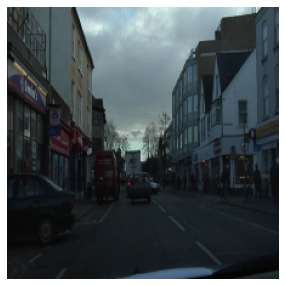

In [ ]:
show(train_ds[10][0])

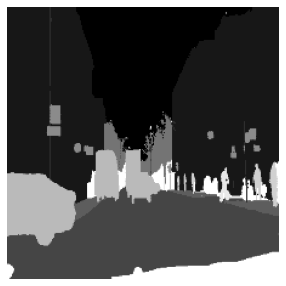

In [ ]:
show(train_ds[10][1])

**Step-4:** Define the neural network model.

We are sequentially performing the `Conv2d` operation, the `BatchNorm2d` operation, and the `ReLU` operation.

Let's define the convolution block.

In [ ]:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

`ConvTranspose2d` ensures that we upscale the images. This differs
from the `Conv2d` operation, where we reduce the dimensions of the
image. It takes an image that has `in_channels` number of channels as
input channels and produces an image that has `out_channels`
number of output channels.

Let's define the up_conv block.

In [ ]:
def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
      nn.ReLU(inplace=True)
  )

We are making the U-style connection between the downscaling and upscaling convolution features by using `torch.cat` on the appropriate pairs of tensors.

Let's define the network class (UNet).

In [ ]:
class UNet(nn.Module):

  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()

    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])
    
    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512+512, 512)

    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256+512, 256)

    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128+256, 128)

    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64+128, 64)

    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32+64, 32)

    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x

Let's define a function (UNetLoss) that will calculate our loss and accuracy
values:

In [ ]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  acc = (torch.max(preds, 1)[1] == targets).float().mean()

  return ce_loss, acc

Let's define a function that will train on batch (`train_batch`) and calculate
metrics on the validation dataset (`validate_batch`):

In [ ]:
def train_batch(model, data, optimizer, criterion):
  model.train()

  ims, ce_masks = data
  _masks = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()

  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()

  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks, masks)

  return loss.item(), acc.item()

Let's define the model, optimizer, loss function, and the number of epochs:

In [ ]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

**Step-5:** Train the model over increasing epochs.

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dataloader)
    for bx, data in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dataloader)
    for bx, data in enumerate(val_dataloader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.138	trn_acc: 0.733	val_loss: 0.849	val_acc: 0.790	(1074.43s - 20414.20s remaining)
EPOCH: 2.000	trn_loss: 0.687	trn_acc: 0.822	val_loss: 0.646	val_acc: 0.844	(2152.43s - 19371.87s remaining)
EPOCH: 3.000	trn_loss: 0.552	trn_acc: 0.850	val_loss: 0.567	val_acc: 0.851	(3223.51s - 18266.54s remaining)
EPOCH: 4.000	trn_loss: 0.505	trn_acc: 0.862	val_loss: 0.508	val_acc: 0.860	(4292.75s - 17171.00s remaining)
EPOCH: 5.000	trn_loss: 0.472	trn_acc: 0.869	val_loss: 0.482	val_acc: 0.865	(5364.96s - 16094.89s remaining)
EPOCH: 6.000	trn_loss: 0.434	trn_acc: 0.879	val_loss: 0.530	val_acc: 0.846	(6439.35s - 15025.15s remaining)
EPOCH: 7.000	trn_loss: 0.420	trn_acc: 0.880	val_loss: 0.455	val_acc: 0.862	(7509.76s - 13946.70s remaining)
EPOCH: 8.000	trn_loss: 0.378	trn_acc: 0.892	val_loss: 0.518	val_acc: 0.831	(8587.07s - 12880.60s remaining)
EPOCH: 9.000	trn_loss: 0.359	trn_acc: 0.898	val_loss: 0.492	val_acc: 0.857	(9667.44s - 11815.76s remaining)
EPOCH: 10.000	trn_loss: 0.33

**Step-6:** Plot the training, validation loss, and accuracy values over increasing epochs:

100%|██████████| 121/121 [00:00<00:00, 737.01it/s]


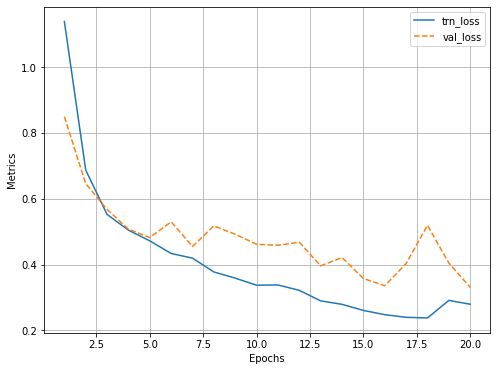

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

**Step-7:** Calculate the predicted output on a new image.

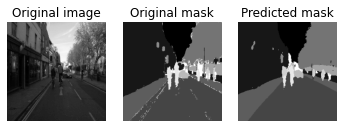

In [ ]:
im, mask = next(iter(val_dataloader))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], 
          mask.permute(1,2,0).detach().cpu()[:,:,0],
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],
          nc=3, titles=['Original image','Original mask','Predicted mask']
        )

We can see that we can successfully generate a segmentation mask using the U-Net architecture. However, all instances of the same class will have the same predicted pixel value. 

What if we want to separate the instances of the Person class in the image? So, we will learn about the **Mask R-CNN** architecture, which helps with generating instance-level masks so that we can differentiate between instances (even instances of the same class).